# [1D-BASELINE] Exp5: Fast Positive Swing LEFT

## Import

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
import datetime
import time
from IPython.display import clear_output

In [4]:
from grace.system import Grace
from grace.capture import LeftEyeCapture, RightEyeCapture
from grace.utils import get_center_chessboard_point, generate_triangle_wave

## Initialization

In [5]:
# Instantiation
grace = Grace(degrees=True)
left_cam = LeftEyeCapture()

[ROS Client] ROS Connection Successful at http://BodyNC-NUC:9090


In [6]:
# Experiment Helper Functions

def px_to_deg_fx(x):
    x = math.atan(x/569.4456315)  #LEFT: fx = 569.4456315. fy = 571.54490033
    x = math.degrees(x)
    return x

def save_pickle_data(data, camera: str, name: str):
    # Making Directory
    filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f") + "_" + camera + "_" + name
    filepath = os.path.join(os.path.abspath(".."), "const_results", filename)

    # Saving to Pickle File
    with open(filepath + ".pickle", 'wb') as file:
        pickle.dump(data, file)
    print('Data saved in:', filepath + ".pickle")
    return filepath + ".pickle"

def slow_reset():
    grace.slow_move_left_eye_pan(angle=-8, step_size=0.0879, time_interval=0.015)
    state = grace.slow_centering_eyes()
    return state
    
def tilt_slow_reset():
    slow_reset()
    state = grace.move_left_eye((None, 0))
    return state
    
def generate_graphs(data, tilt, x_org):
    tilt_idx = tilt_arr.index(tilt)
    
    # Input Array
    plt.figure()
    input_arr  = data["input_arr"]
    plt.plot(input_arr, marker='.',)
    plt.ylim([-20, 20])
    plt.xlabel('Samples')
    plt.ylabel('Input Angle (deg)')
    plt.title('Input Motor Command')
    
    
    ### ('=============Initial Pixel===============')
    
    # Pixel vs Input Array (Raw)
    raw_x_pixel_arr = [x[0] for x in data["init_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, raw_x_pixel_arr, color='orange', marker='.', linestyle="None")
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Pixel X Value')
    plt.title('{Initial Raw Pixel Position')
    plt.grid()
    
    # Pixel vs Input Array (Raw)
    x_pixel_arr = [x_org-x[0] for x in data["init_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, x_pixel_arr, color='orange', marker='.',  linestyle="None")
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Delta Pixel X Value (wrt 320 px)')
    plt.title('Initial Raw Pixel Position')
    plt.grid()
    
    # Time Series Eye Output vs Input Array
    phi = [px_to_deg_fx(x_org-x[0]) for x in data["init_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.figure()
    plt.plot(input_arr, phi, color="orange", marker='.', linestyle="None")
    plt.xlabel('Input Command')
    plt.ylabel('Eye Output')
    plt.title('Initial Pixel Robot Data')
    plt.grid()    
    
    # Histogram (Pixels)
    plt.figure()
    plt.hist(x_pixel_arr)
    plt.xlabel("pixels")
    plt.ylabel("n")
    plt.title("Initial Pixel Distribution")
    mean_val = np.mean(np.array(x_pixel_arr))
    std_val = np.std(np.array(x_pixel_arr))
    print("Init Mean (px):", mean_val)
    print("Init Std (px):", std_val)
    
    
    # Histogram (Angle)
    plt.figure()
    plt.hist(phi)
    plt.xlabel("degrees")
    plt.ylabel("n")
    plt.title("Initial Angle Distribution")
    mean_val = np.mean(np.array(phi))
    std_val = np.std(np.array(phi))
    print("Init Mean (deg):", mean_val)
    print("Init Std (deg):", std_val)
    
    
    ### ('=============Pixel===============')
    
    # Pixel vs Input Array (Raw)
    raw_x_pixel_arr = [x[0] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, raw_x_pixel_arr, color='orange', marker='.', linestyle="None")
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Pixel X Value')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Pixel vs Input Array (Raw)
    x_pixel_arr = [x_org-x[0] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, x_pixel_arr, color='orange', marker='.',  linestyle="None")
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Delta Pixel X Value (wrt 320 px)')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Time Series Eye Output vs Input Array
    phi = [px_to_deg_fx(x_org-x[0]) for x in data["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.figure()
    plt.plot(input_arr, phi, color="orange", marker='.', linestyle="None")
    plt.xlabel('Input Command')
    plt.ylabel('Eye Output')
    plt.title('Robot Data')
    plt.grid() 
    
    # Histogram (Pixels)
    plt.figure()
    plt.hist(x_pixel_arr)
    plt.xlabel("pixels")
    plt.ylabel("n")
    plt.title("Target Pixel Distribution")
    mean_val = np.mean(np.array(x_pixel_arr))
    std_val = np.std(np.array(x_pixel_arr))
    print("Target Mean (px):", mean_val)
    print("Target Std (px):", std_val)
    
    
    # Histogram (Angle)
    plt.figure()
    plt.hist(phi)
    plt.xlabel("degrees")
    plt.ylabel("n")
    plt.title("Target Angle Distribution")
    mean_val = np.mean(np.array(phi))
    std_val = np.std(np.array(phi))
    print("Target Mean (deg):", mean_val)
    print("Target Std (deg):", std_val)
    

In [7]:
# Initialization

pickle_data = {
    "title": "[1D-BASELINE] Exp5: FastPositiveSwing",
    "description": None,
    "data_label": ["16amp","8amp","4amp","2amp"],
    "data": None,
    "datetime": datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
}

data_list = []

In [8]:
# Center the left eye

state = tilt_slow_reset()
pixel_state = get_center_chessboard_point(left_cam.frame)
print(state)
print(pixel_state)

(0.0, 0.0)
[316.39520263671875, 203.03855895996094]


## EXP5.1. 16 Degrees Amplitude

In [9]:
# Parameters

input = 11
trials = 10
time_interval = 0.015  # sec

tilt_arr = [0]

In [10]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep 
    "input_arr": [],  # Data points or Triangle Wave
    "init_arr": [],  # Initial data points as point of reference
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


Text(0, 0.5, 'Input Angle (deg)')

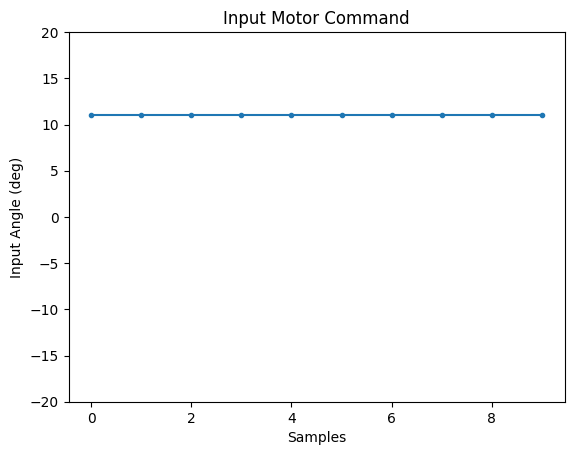

In [11]:
# Generation of triangle wave

input_arr = [input]*trials
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr, marker='.')
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [12]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr

start = time.time()

# Initial State
tilt_slow_reset()
time.sleep(0.75)


cnt = 0
for tilt in tilt_arr:
    init_arr = []
    pixel_arr = []
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)

        
        # Init Position
        in_cnt = 0
        while(in_cnt < 5):
            try:
                init_pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        init_arr.append(init_pixel_pt)
        
        
        # Fast Move
        state = grace.direct_move_left_eye((pan, tilt))
        time.sleep(0.75)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)

        
        # Slow Centering Eyes
        state = tilt_slow_reset()
        time.sleep(time_interval)
        
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    
    data["pixel_arr"].append(pixel_arr)
    data["init_arr"].append(init_arr)
    
    
    # End State
    tilt_slow_reset()
    time.sleep(0.75)
    data["end_motor_state"].append(grace.state)
    data["end_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

print("Elapsed Time:", time.time()-start)

10/10
pan:11, tilt:0
Elapsed Time: 100.94828820228577


In [13]:
# Checking of Data

data["init_arr"]

[[[315.73858642578125, 202.7000274658203],
  [315.7445068359375, 202.70962524414062],
  [316.3766784667969, 202.80035400390625],
  [315.9338073730469, 202.66387939453125],
  [316.1031188964844, 202.7340850830078],
  [315.9714660644531, 202.72531127929688],
  [315.61029052734375, 202.6504364013672],
  [315.4750671386719, 202.57369995117188],
  [315.3863525390625, 202.56033325195312],
  [315.90032958984375, 202.6015167236328]]]

In [14]:
# Checking of Data

data["pixel_arr"]

[[[131.91407775878906, 200.296142578125],
  [132.3640594482422, 200.59869384765625],
  [130.50286865234375, 199.78770446777344],
  [132.42715454101562, 200.51736450195312],
  [131.93563842773438, 200.24563598632812],
  [132.09124755859375, 200.50270080566406],
  [131.26722717285156, 199.92185974121094],
  [132.0990753173828, 200.2513427734375],
  [132.1112060546875, 200.4815216064453],
  [131.96588134765625, 200.51014709472656]]]

Init Mean (px): -0.8240203857421875
Init Std (px): 0.2820579319541384
Init Mean (deg): -0.08291018991691418
Init Std (deg): 0.02837968741240995
Target Mean (px): 183.1321563720703
Target Std (px): 0.544233723076666
Target Mean (deg): 17.827634873750306
Target Std (deg): 0.04960561816634878


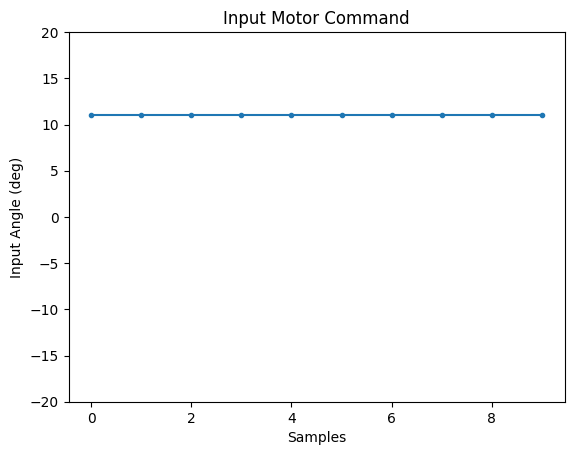

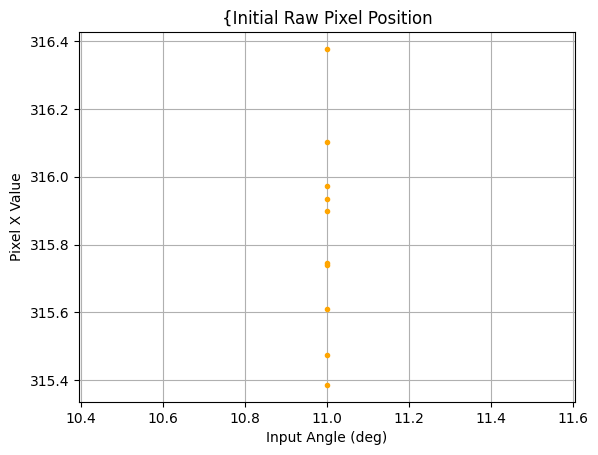

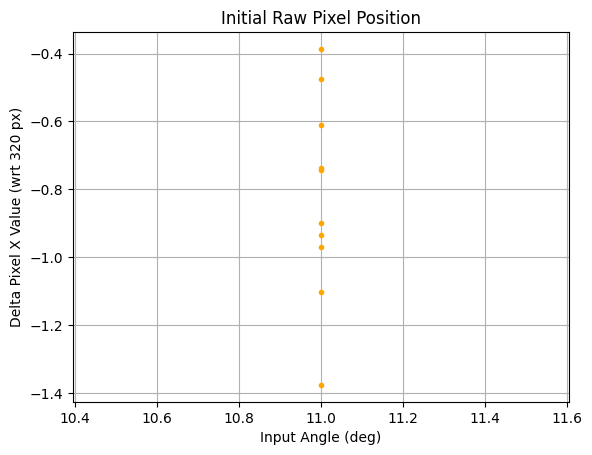

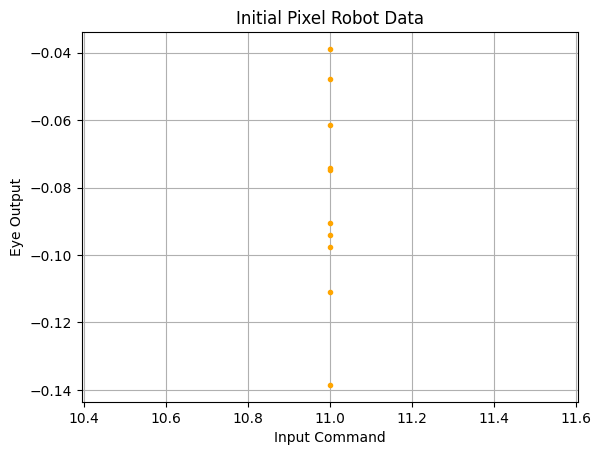

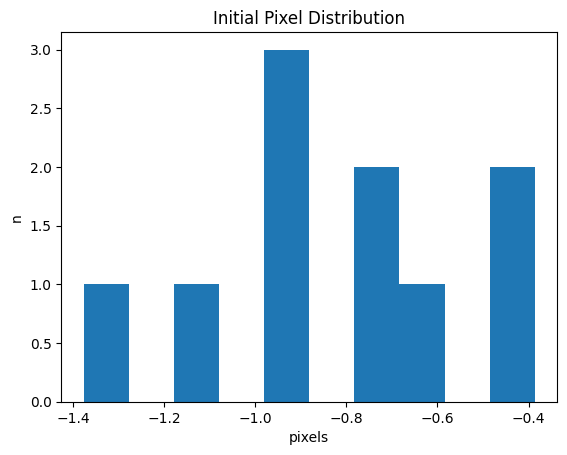

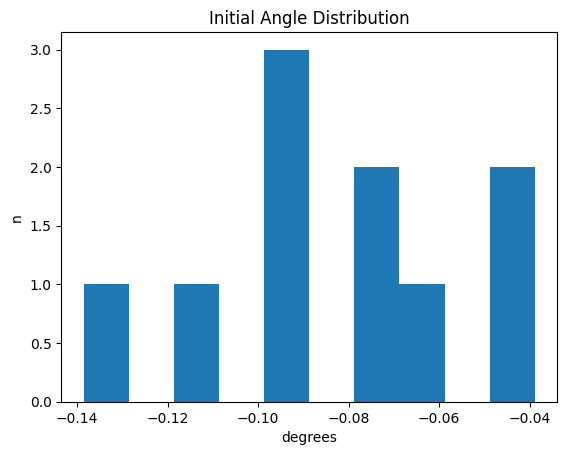

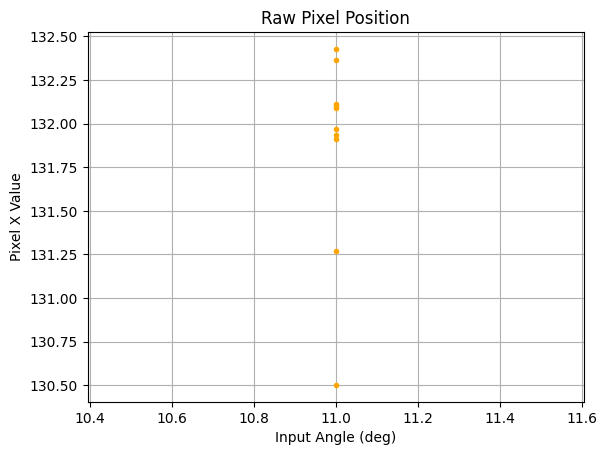

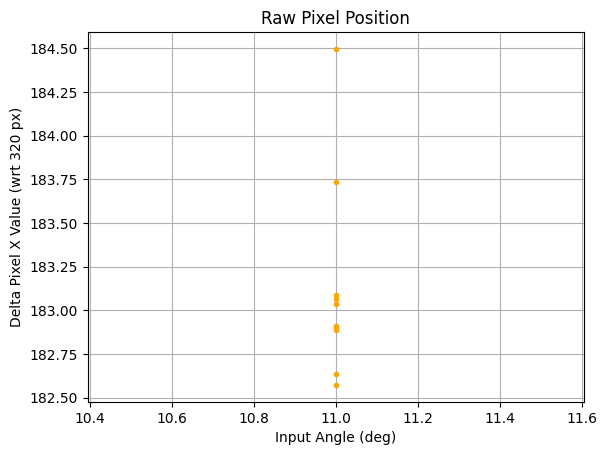

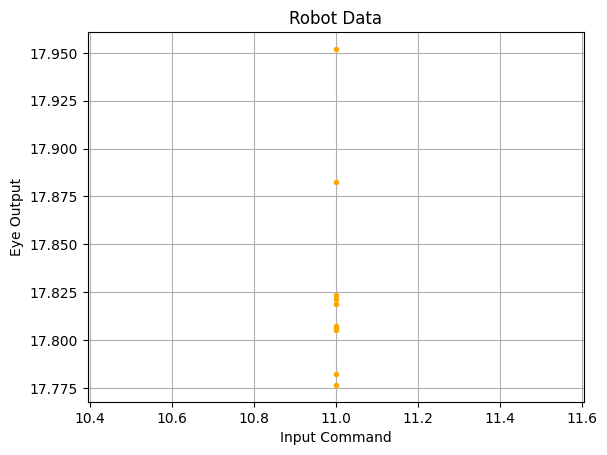

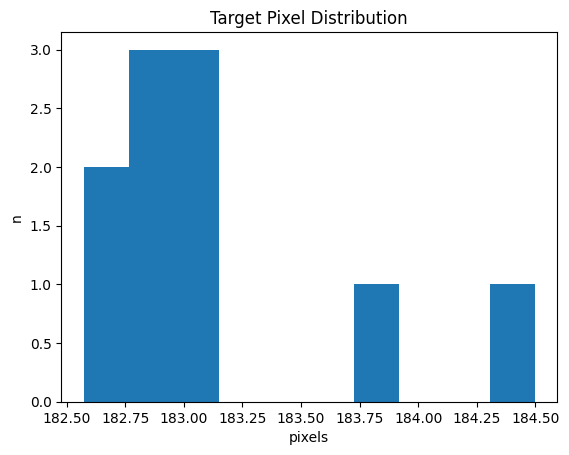

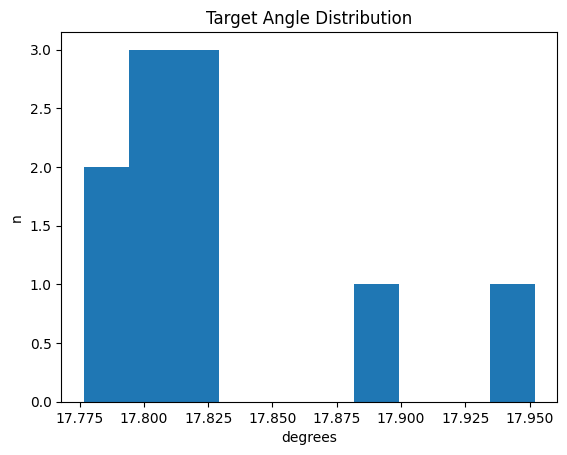

In [15]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=315)

In [16]:
# Saving to External Variable

data16 = data

In [17]:
# Appending to Data List

data_list.append(data16)

## EXP5.2. 8 Degrees Amplitude

In [18]:
# Parameters

input = 8
trials = 10
time_interval = 0.015  # sec

tilt_arr = [0]

In [19]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep 
    "input_arr": [],  # Data points or Triangle Wave
    "init_arr": [],  # Initial data points as point of reference
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


Text(0, 0.5, 'Input Angle (deg)')

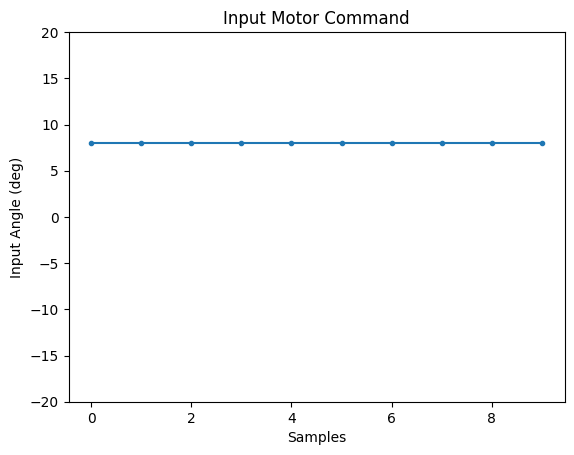

In [20]:
# Generation of triangle wave

input_arr = [input]*trials
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr, marker='.')
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [21]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr

start = time.time()

# Initial State
tilt_slow_reset()
time.sleep(0.75)


cnt = 0
for tilt in tilt_arr:
    init_arr = []
    pixel_arr = []
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)

        
        # Init Position
        in_cnt = 0
        while(in_cnt < 5):
            try:
                init_pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        init_arr.append(init_pixel_pt)
        
        
        # Fast Move
        state = grace.direct_move_left_eye((pan, tilt))
        time.sleep(0.75)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)

        
        # Slow Centering Eyes
        state = tilt_slow_reset()
        time.sleep(time_interval)
        
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    
    data["pixel_arr"].append(pixel_arr)
    data["init_arr"].append(init_arr)
    
    
    # End State
    tilt_slow_reset()
    time.sleep(0.75)
    data["end_motor_state"].append(grace.state)
    data["end_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

print("Elapsed Time:", time.time()-start)

10/10
pan:8, tilt:0
Elapsed Time: 92.69062423706055


In [22]:
# Checking of Data

data["init_arr"]

[[[316.1789855957031, 202.6959991455078],
  [316.264892578125, 202.7056121826172],
  [315.8466491699219, 202.64979553222656],
  [315.4952087402344, 202.58041381835938],
  [315.6531066894531, 202.56365966796875],
  [315.81396484375, 202.6609649658203],
  [316.245849609375, 202.68177795410156],
  [315.4916687011719, 202.5363311767578],
  [315.96173095703125, 202.66360473632812],
  [315.7726745605469, 202.5880584716797]]]

In [23]:
# Checking of Data

data["pixel_arr"]

[[[183.7984619140625, 200.67576599121094],
  [181.8592987060547, 200.65618896484375],
  [184.114990234375, 200.66680908203125],
  [184.17724609375, 200.7683868408203],
  [182.01724243164062, 200.58213806152344],
  [183.4221954345703, 200.563232421875],
  [183.24595642089844, 200.5355682373047],
  [185.12425231933594, 201.1227264404297],
  [184.7223663330078, 200.87326049804688],
  [184.8952178955078, 200.92909240722656]]]

Init Mean (px): -0.87247314453125
Init Std (px): 0.27291606565250337
Init Mean (deg): -0.08778533969070676
Init Std (deg): 0.027459862507065967
Target Mean (px): 131.26227722167968
Target Std (px): 1.067750159847727
Target Mean (deg): 12.980411535530171
Target Std (deg): 0.1019904162432371


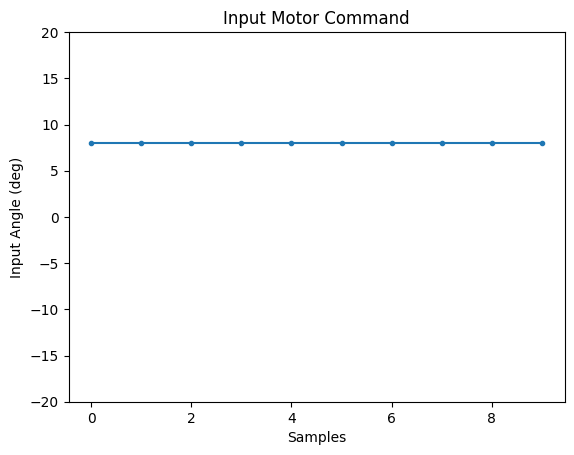

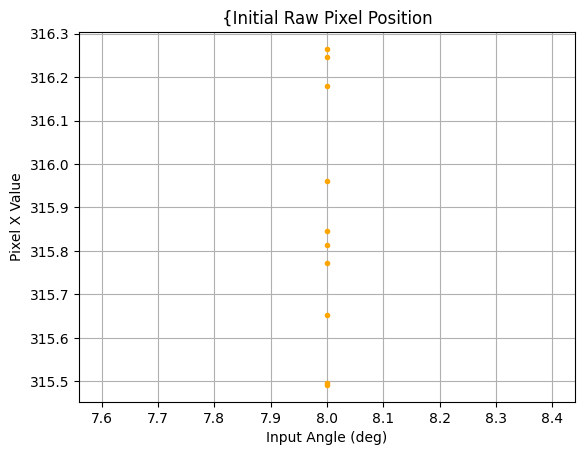

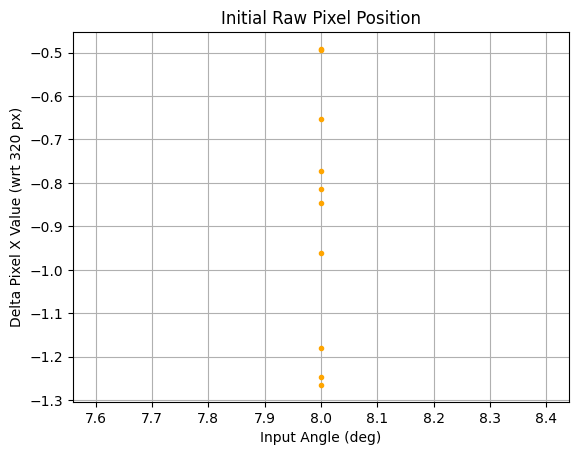

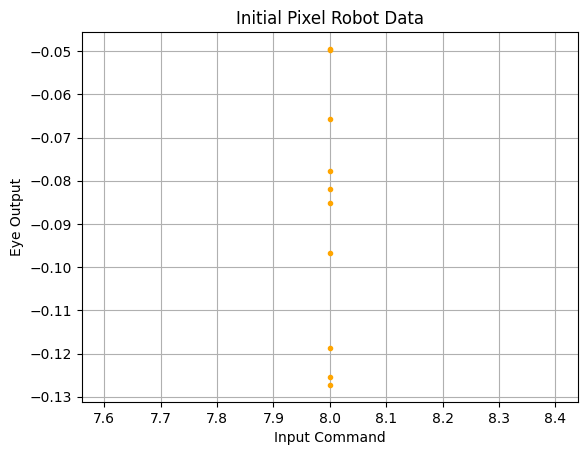

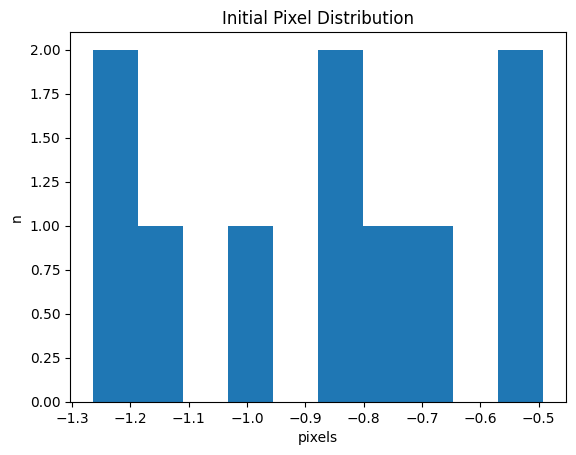

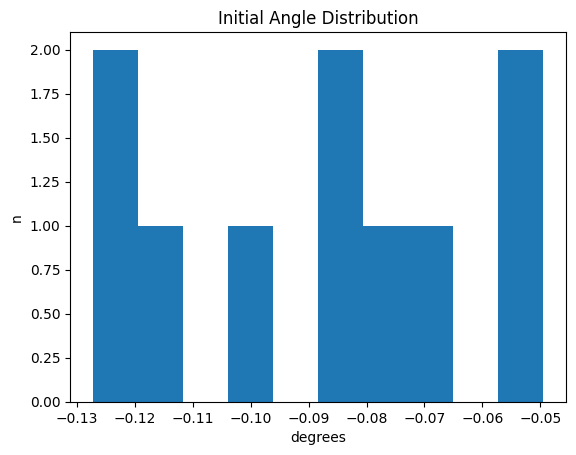

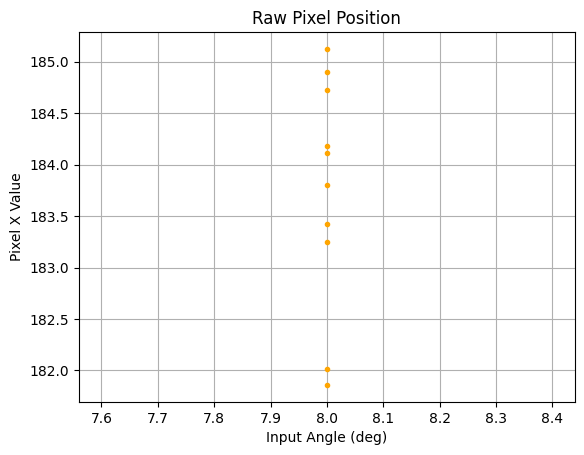

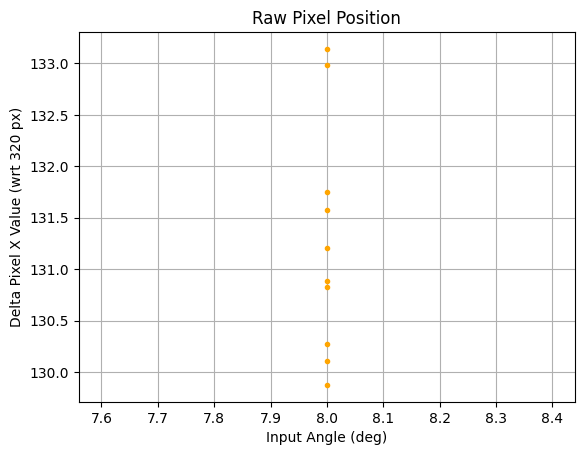

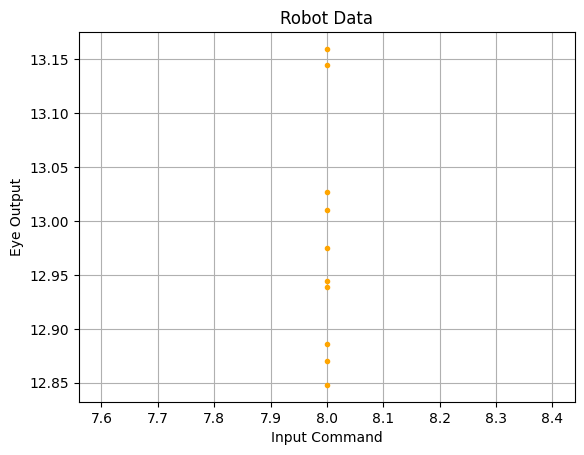

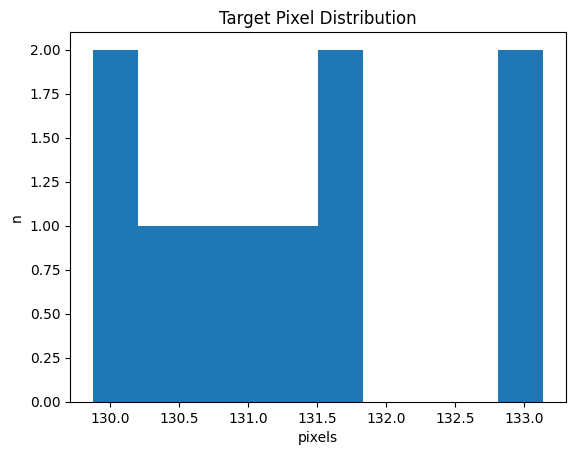

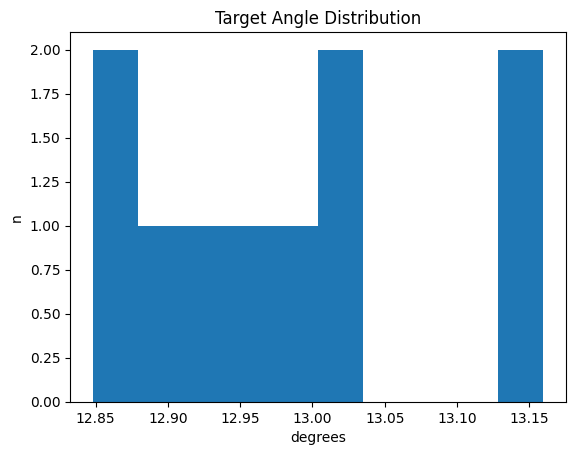

In [24]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=315)

In [25]:
# Saving to External Variable

data8 = data

In [26]:
# Appending to Data List

data_list.append(data8)

## EXP5.3. 4 Degrees Amplitude

In [27]:
# Parameters

input = 4
trials = 10
time_interval = 0.015  # sec

tilt_arr = [0]

In [28]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep 
    "input_arr": [],  # Data points or Triangle Wave
    "init_arr": [],  # Initial data points as point of reference
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Text(0, 0.5, 'Input Angle (deg)')

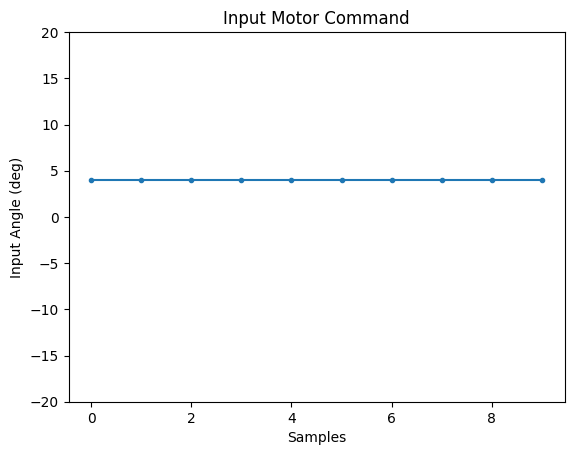

In [29]:
# Generation of triangle wave

input_arr = [input]*trials
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr, marker='.')
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [30]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr

start = time.time()

# Initial State
tilt_slow_reset()
time.sleep(0.75)


cnt = 0
for tilt in tilt_arr:
    init_arr = []
    pixel_arr = []
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)

        
        # Init Position
        in_cnt = 0
        while(in_cnt < 5):
            try:
                init_pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        init_arr.append(init_pixel_pt)
        
        
        # Fast Move
        state = grace.direct_move_left_eye((pan, tilt))
        time.sleep(0.75)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)

        
        # Slow Centering Eyes
        state = tilt_slow_reset()
        time.sleep(time_interval)
        
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    
    data["pixel_arr"].append(pixel_arr)
    data["init_arr"].append(init_arr)
    
    
    # End State
    tilt_slow_reset()
    time.sleep(0.75)
    data["end_motor_state"].append(grace.state)
    data["end_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

print("Elapsed Time:", time.time()-start)

10/10
pan:4, tilt:0
Elapsed Time: 85.07941126823425


In [31]:
# Checking of Data

data["init_arr"]

[[[315.8989562988281, 202.57186889648438],
  [315.7734680175781, 202.57545471191406],
  [315.6883850097656, 202.53726196289062],
  [316.1836853027344, 202.6577911376953],
  [315.87530517578125, 202.57420349121094],
  [315.81695556640625, 202.5758514404297],
  [315.64129638671875, 202.57601928710938],
  [316.07232666015625, 202.6005859375],
  [315.74481201171875, 202.57327270507812],
  [315.7480773925781, 202.5677032470703]]]

In [32]:
# Checking of Data

data["pixel_arr"]

[[[251.06210327148438, 201.55035400390625],
  [250.6516571044922, 201.53858947753906],
  [248.0981903076172, 201.56283569335938],
  [250.8131866455078, 201.5379180908203],
  [246.98020935058594, 201.4747314453125],
  [251.11155700683594, 201.5330352783203],
  [247.57933044433594, 201.49972534179688],
  [248.18675231933594, 201.57069396972656],
  [247.09190368652344, 201.45367431640625],
  [251.34596252441406, 201.562255859375]]]

Init Mean (px): -0.8443267822265625
Init Std (px): 0.1617308428119927
Init Mean (deg): -0.08495336324664968
Init Std (deg): 0.016272791933937446
Target Mean (px): 65.70791473388672
Target Std (px): 1.7490077856755684
Target Mean (deg): 6.582146956817283
Target Std (deg): 0.17366111230237924


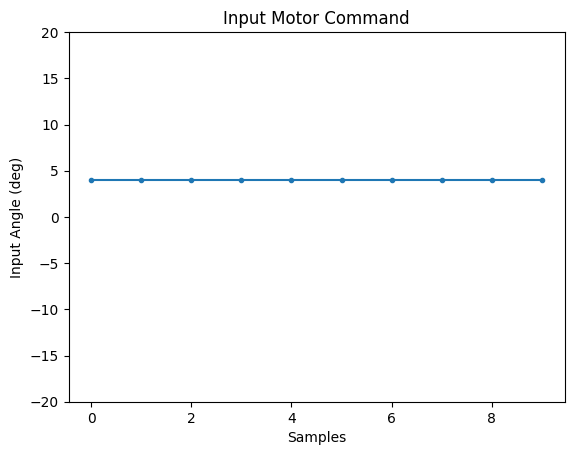

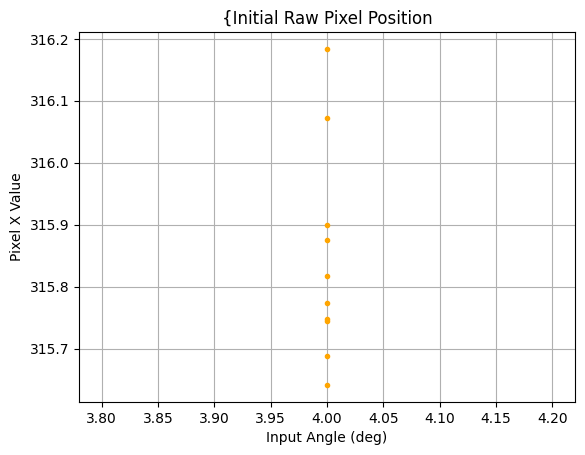

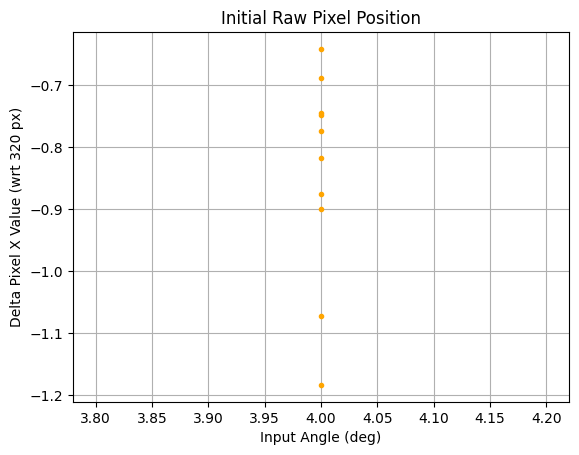

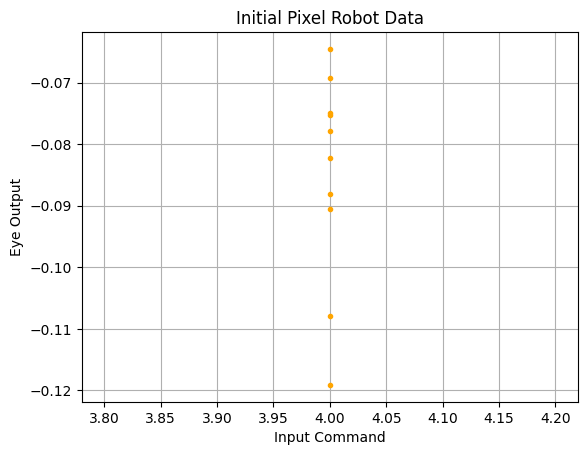

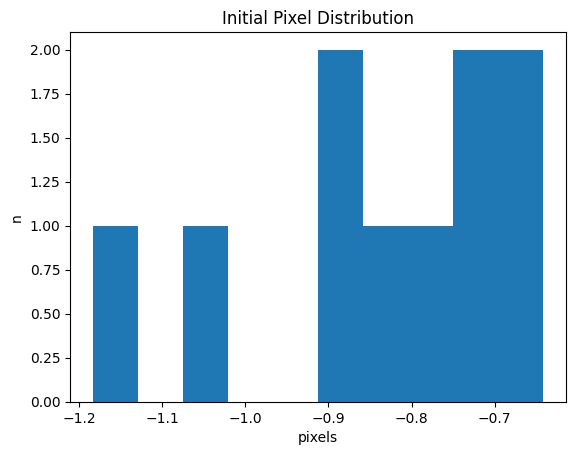

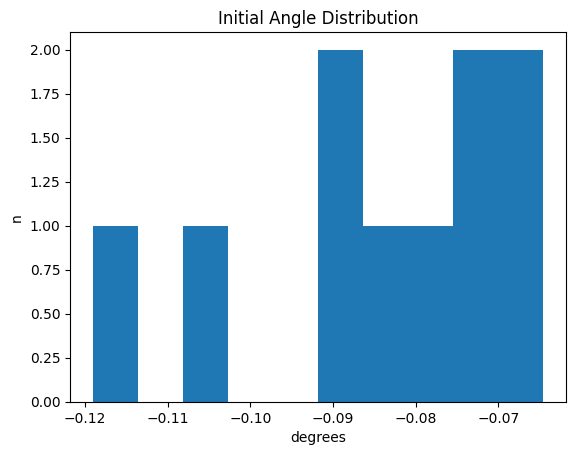

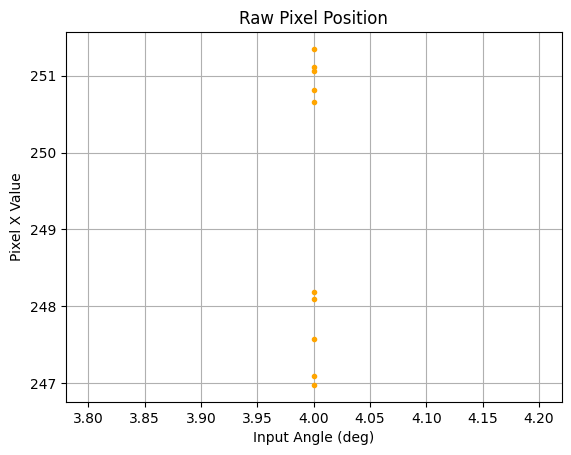

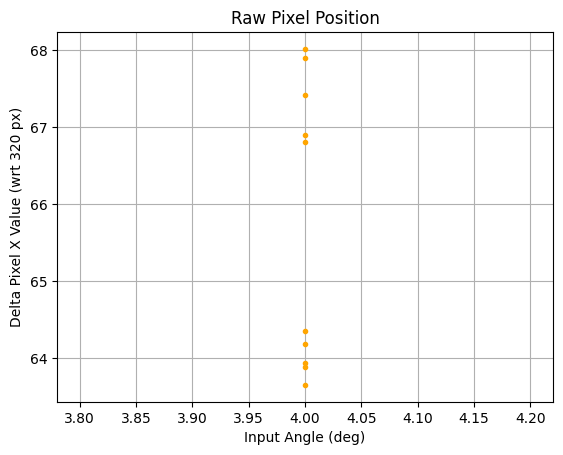

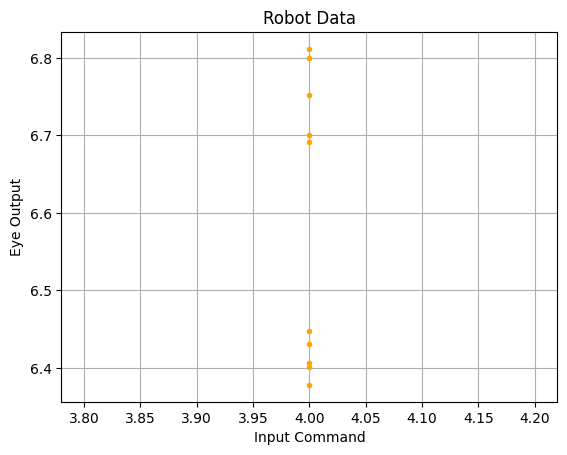

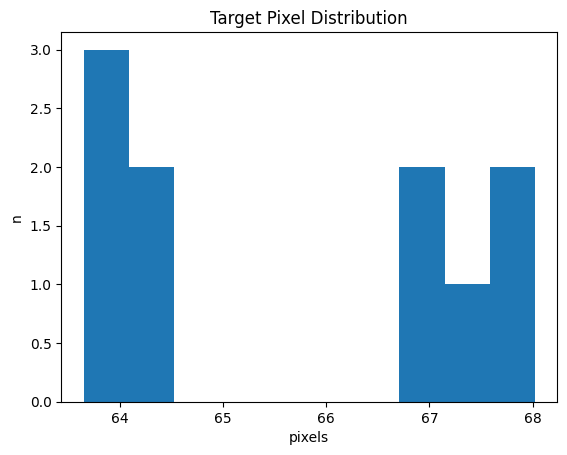

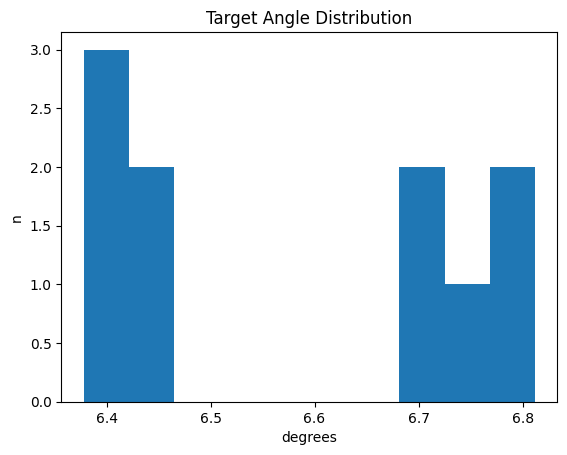

In [33]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=315)

In [34]:
# Saving to External Variable

data4 = data

In [35]:
# Appending to Data List

data_list.append(data4)

## EXP5.4. 2 Degrees Amplitude

In [36]:
# Parameters

input = 2
trials = 10
time_interval = 0.015  # sec

tilt_arr = [0]

In [37]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep 
    "input_arr": [],  # Data points or Triangle Wave
    "init_arr": [],  # Initial data points as point of reference
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


Text(0, 0.5, 'Input Angle (deg)')

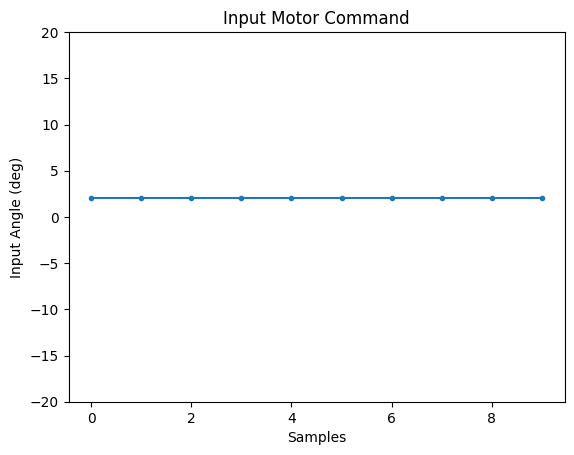

In [38]:
# Generation of triangle wave

input_arr = [input]*trials
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr, marker='.')
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [39]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr

start = time.time()

# Initial State
tilt_slow_reset()
time.sleep(0.75)


cnt = 0
for tilt in tilt_arr:
    init_arr = []
    pixel_arr = []
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)

        
        # Init Position
        in_cnt = 0
        while(in_cnt < 5):
            try:
                init_pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        init_arr.append(init_pixel_pt)
        
        
        # Fast Move
        state = grace.direct_move_left_eye((pan, tilt))
        time.sleep(0.75)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)

        
        # Slow Centering Eyes
        state = tilt_slow_reset()
        time.sleep(time_interval)
        
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    
    data["pixel_arr"].append(pixel_arr)
    data["init_arr"].append(init_arr)
    
    
    # End State
    tilt_slow_reset()
    time.sleep(0.75)
    data["end_motor_state"].append(grace.state)
    data["end_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

print("Elapsed Time:", time.time()-start)

10/10
pan:2, tilt:0
Elapsed Time: 81.3073377609253


In [40]:
# Checking of Data

data["init_arr"]

[[[316.0419006347656, 202.592041015625],
  [315.7574157714844, 202.5550537109375],
  [316.1748962402344, 202.60760498046875],
  [316.6301574707031, 202.67230224609375],
  [316.2926940917969, 202.66412353515625],
  [315.80206298828125, 202.54136657714844],
  [315.95220947265625, 202.53269958496094],
  [315.5520935058594, 202.45567321777344],
  [316.2237548828125, 202.5579833984375],
  [315.5314636230469, 202.48207092285156]]]

In [41]:
# Checking of Data

data["pixel_arr"]

[[[282.4502258300781, 201.95652770996094],
  [282.69500732421875, 201.89761352539062],
  [281.2798156738281, 201.94642639160156],
  [284.84747314453125, 202.16549682617188],
  [281.2176818847656, 201.9552764892578],
  [282.6044616699219, 201.93617248535156],
  [285.2264099121094, 202.2230682373047],
  [283.6703796386719, 201.8501434326172],
  [284.4548645019531, 202.07017517089844],
  [283.46490478515625, 201.85382080078125]]]

Init Mean (px): -0.9958648681640625
Init Std (px): 0.3294638900980257
Init Mean (deg): -0.10020056867922025
Init Std (deg): 0.03314947395214584
Target Mean (px): 31.808877563476564
Target Std (px): 1.3219066161412962
Target Mean (deg): 3.197166744181594
Target Std (deg): 0.13259161404662775


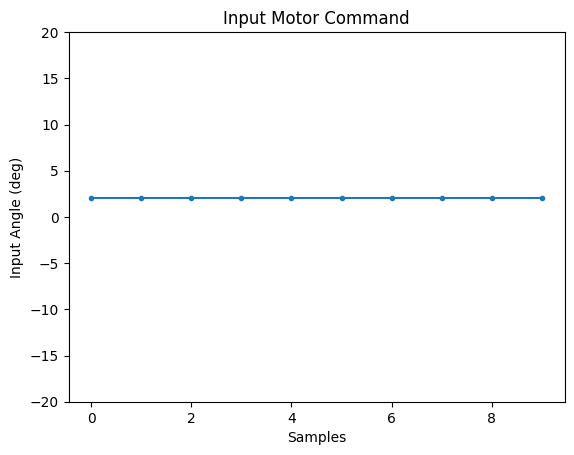

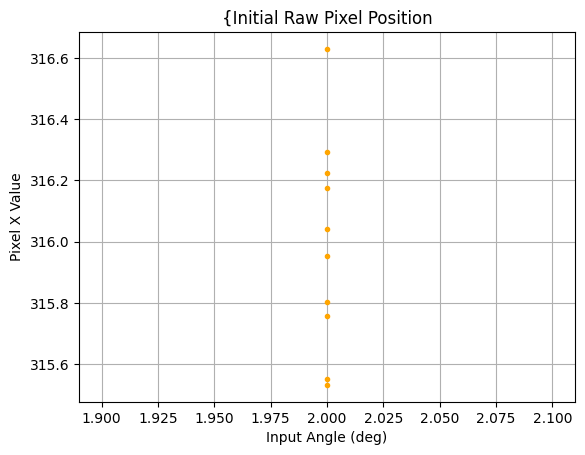

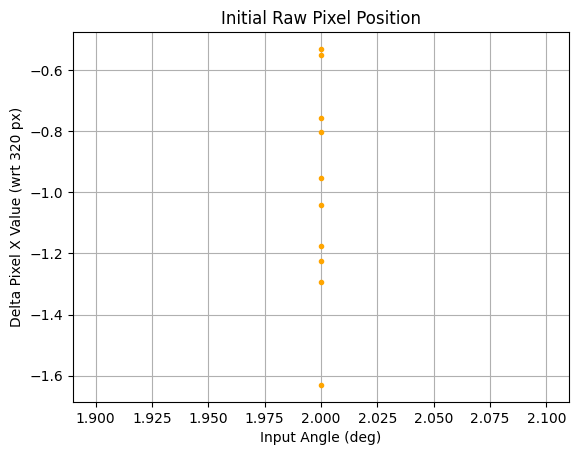

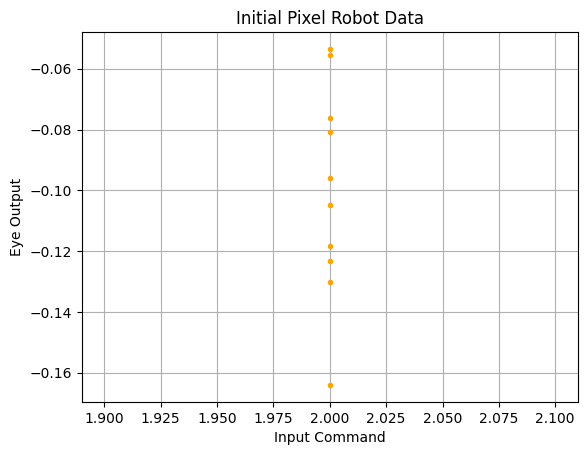

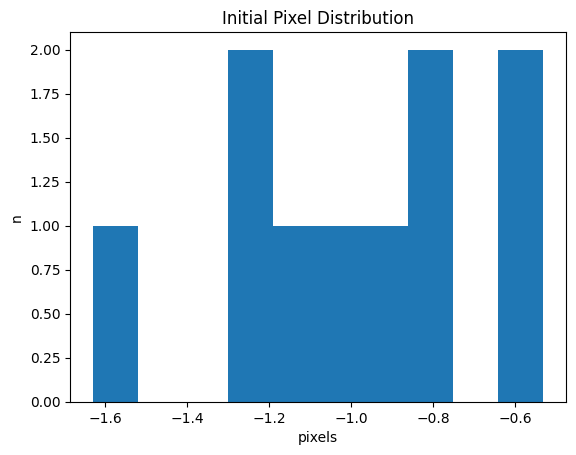

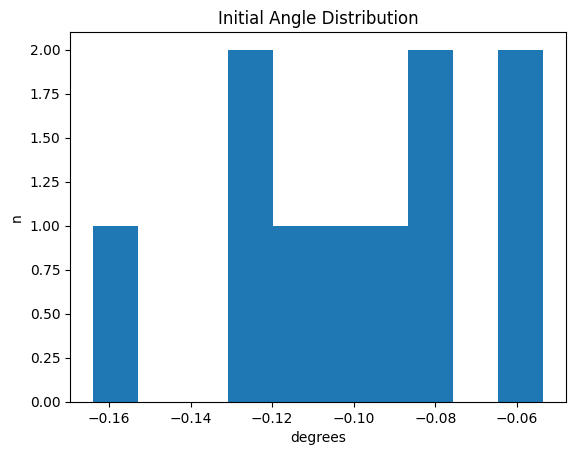

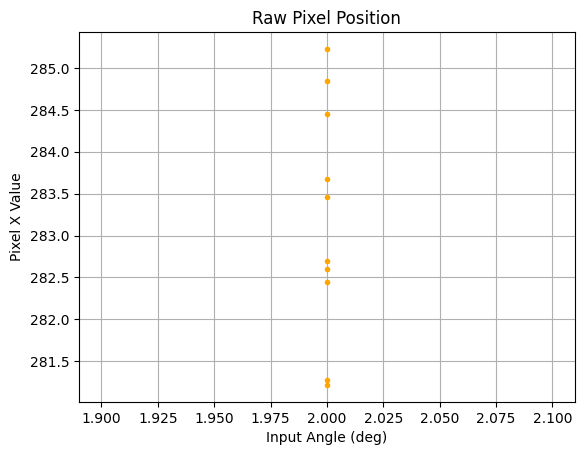

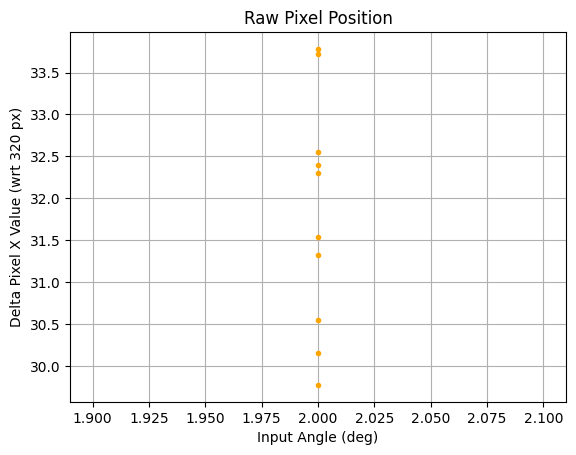

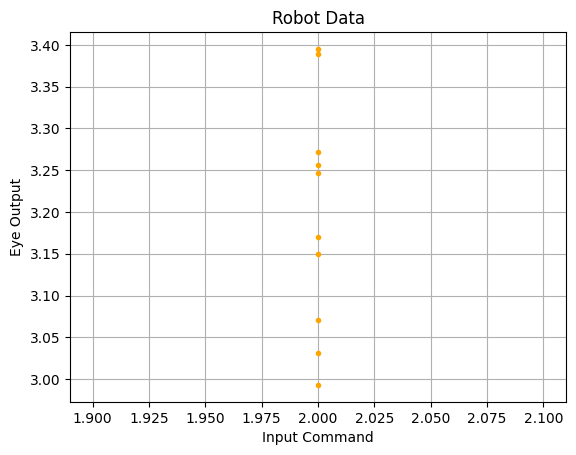

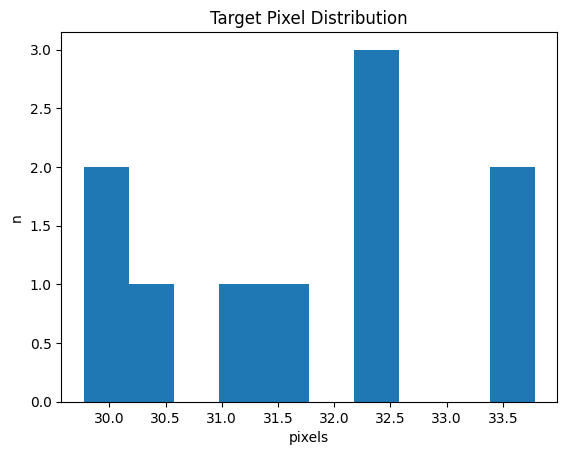

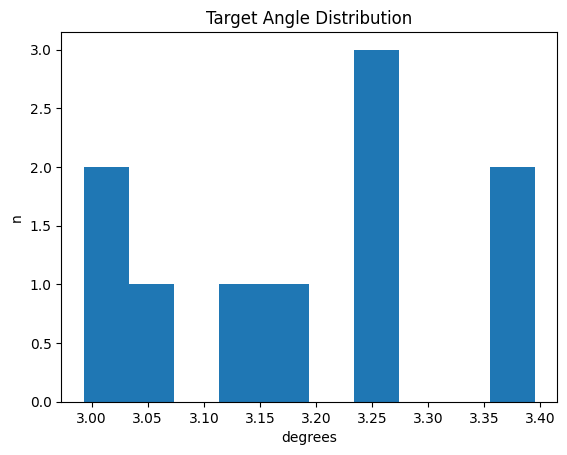

In [42]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=315)

In [43]:
# Saving to External Variable

data2 = data

In [44]:
# Appending to Data List

data_list.append(data2)

# Saving the Data

In [45]:
pickle_data["data"] = data_list
data_filepath = save_pickle_data(pickle_data, camera="left", name="1D-BASELINE_EXP5_FastPositiveSwing")

Data saved in: C:\dev\robot_control\const_results\20230530_004045_812511_left_1D-BASELINE_EXP5_FastPositiveSwing.pickle


# Loading the Data

In [46]:
# Opening of Pickle File

with open(data_filepath, 'rb') as file:
    data_load = pickle.load(file)

## Data Analysis

In [60]:
def random_colors(n):
    return np.random.rand(n,3)

rand_colors = random_colors(len(data_load["data"]))

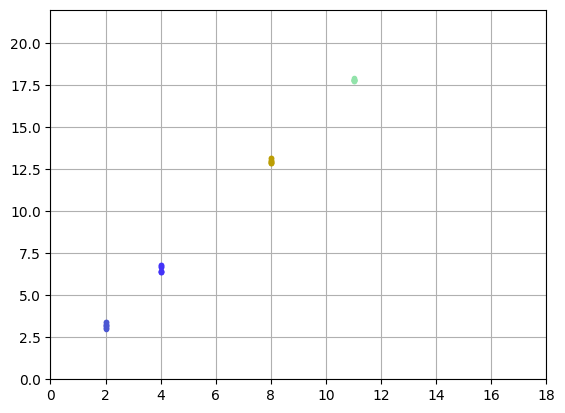

In [61]:
# Parameter
x_org = 320
tilt_idx = 0

for i in range(len(data_load["data"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, marker='.', linestyle=None, color=rand_colors[i])
plt.xlim([0, 18])
plt.ylim([0, 22])
plt.grid()

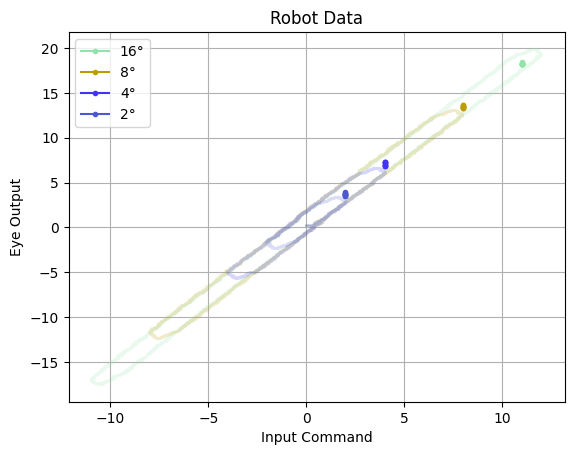

In [62]:
# Data Superposition

# Opening of Pickle File
filename = "20230530_000517_535176_left_1D-BASELINE_EXP1_RobotBaseline.pickle"
fn = os.path.join(os.path.abspath(".."), "const_results",filename)
with open(fn, 'rb') as file:
    baseline_data = pickle.load(file)

# Parameter
x_org = 315
tilt_idx = 0

# Data Captured
for i in range(len(data_load["data"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, marker='.', linestyle=None, color=rand_colors[i])
plt.legend(["16°", "8°", "4°", "2°"])

# Line Data Parameters
for i in range(len(baseline_data["data"])):
    input_arr = baseline_data["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in baseline_data["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.2)
    
plt.xlabel('Input Command')
plt.ylabel('Eye Output')
plt.title('Robot Data')
plt.grid()

(0.0, 22.0)

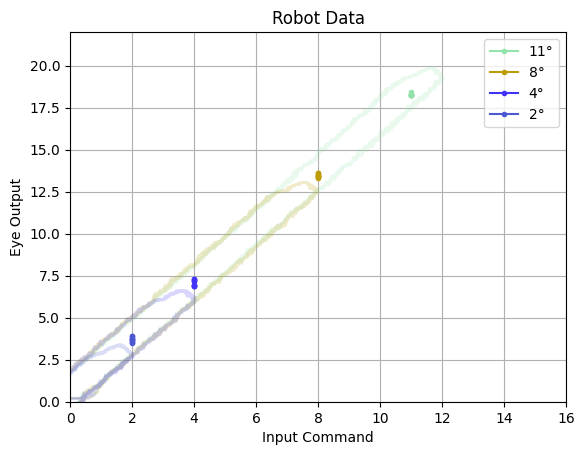

In [64]:
# Data Superposition


# Opening of Pickle File
filename = "20230530_000517_535176_left_1D-BASELINE_EXP1_RobotBaseline.pickle"
fn = os.path.join(os.path.abspath(".."), "const_results",filename)
with open(fn, 'rb') as file:
    baseline_data = pickle.load(file)

# Parameter
x_org = 315
tilt_idx = 0

# Data Captured
for i in range(len(data_load["data"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, marker='.', linestyle=None, color=rand_colors[i])
plt.legend(["11°", "8°", "4°", "2°"])

# Line Data Parameters
for i in range(len(baseline_data["data"])):
    input_arr = baseline_data["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in baseline_data["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.2)
    
plt.xlabel('Input Command')
plt.ylabel('Eye Output')
plt.title('Robot Data')
plt.grid()
plt.xlim([0, 16])
plt.ylim([0, 22])